In [1]:
from pyspark import SparkContext
import numpy as np 
import sys 
from matplotlib import pyplot as plt
from math import radians, sin, cos, sqrt, atan2

In [2]:
sc = SparkContext()

In [12]:
def closest_point(p, ps, m):
    """
    given a (latitude/longitude) point 
    and an array of current center points
    returns the index in the array of 
    the center closest to the given poin
    :param p:  given point
    :param ps: center points
    :param m:  distance functions
    :return:   the index of the closest center point
    """
    ps = np.asarray(ps)
    return np.argmin(m(p, ps))

In [13]:
def add_points(p1, p2):
    """
    given two points, return a point 
    which is the sum of the two points.
    """
    return p1[0] + p2[0], p1[1] + p2[1]


In [14]:
def euclidean_distance(p1, p2):
    """
    calculate the eculidean distance between two points
    :param p1: pair of coordinate
    :param p2: pair of coordinate
    :return: eculidean distance
    """
    return np.sqrt(np.sum((np.array(p2) - np.array(p1))**2, axis = 1))


In [32]:
def great_circle_distance(p1, p2):
    lat1, lon1 = radians(p1[1]), radians(p1[0])
    lat2, lon2 = np.radians(p2[:, 1]), np.radians(p2[:, 0])

    sin_lat1, cos_lat1 = sin(lat1), cos(lat1)
    sin_lat2, cos_lat2 = np.sin(lat2), np.cos(lat2)

    d_lon = np.subtract(lon2, lon1)
    cos_d_lon, sin_d_lon = np.cos(d_lon), np.sin(d_lon)

    return np.arctan2(np.sqrt((cos_lat2 * sin_d_lon) ** 2 +
                 (cos_lat1 * sin_lat2 -
                  sin_lat1 * cos_lat2 * cos_d_lon) ** 2),
                 sin_lat1 * sin_lat2 + cos_lat1 * cos_lat2 * cos_d_lon)

In [16]:
def WCSS(ps, cps):
    """
    Within-Clusters Sum-of-Squares measure
    """
    return sum(np.sum((cps[i] - p) ** 2)  for (i, p) in ps)

In [8]:
def kmeans_cluster(data, converge_dist, m, k):
    cp = data.takeSample(False, k, 20181209)
    temp_dist = 1.0
    while temp_dist > converge_dist:
        closest = data.map(lambda p: (closest_point(p, cp, m), (p, 1)))
        point_stats = closest.reduceByKey(lambda p1, p2: (add_points(p1[0] , p2[0]), p1[1] + p2[1])).map(lambda o: (o[0], np.array(o[1][0]) /o[1][1])).collect()

        temp_dist = WCSS(point_stats, cp)
        for (i, p) in point_stats:
            cp[i] = p
    clusters = data.map(lambda p: (closest_point(p, cp, m), p)).groupByKey().map(lambda o : (o[0],list(o[1]))).collect()
    return cp, clusters

In [3]:
data = sc.textFile("file:///home/mike/Dropbox/workspace/cse427s/k-means/Milestone3/Visualize/device_location_data")\
.map(lambda o: o.split(',')).map(lambda o: (float(o[1]), float(o[0]))).cache()

In [10]:
cp, clusters = kmeans_cluster(data, 0.01, euclidean_distance, 5)

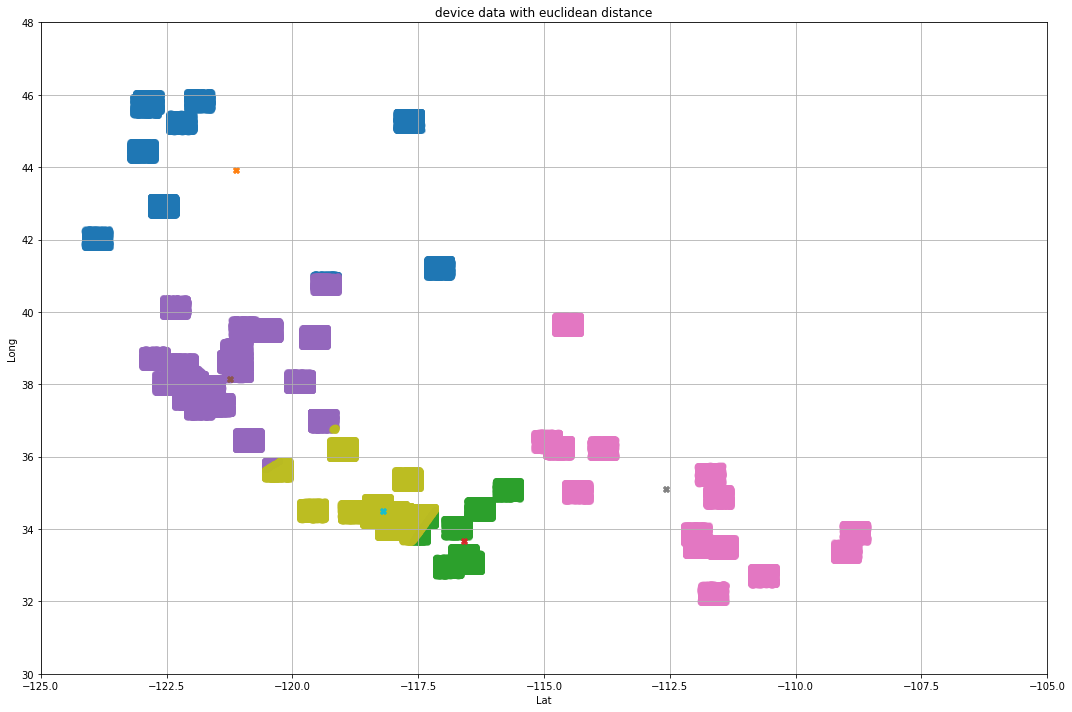

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp[c[0]][0],cp[c[0]][1], marker="X",alpha=1)
    ax.set_ylim((30,48))
    ax.set_xlim((-125,-105))
ax.set_xlabel('Lat', fontsize=10)
ax.set_ylabel('Long', fontsize=10)
ax.set_title('device data with euclidean distance')
ax.grid(True)
fig.tight_layout()

plt.show()

In [12]:
cp_circle, clusters_circle = kmeans_cluster(data, 0.01, great_circle_distance, 5)

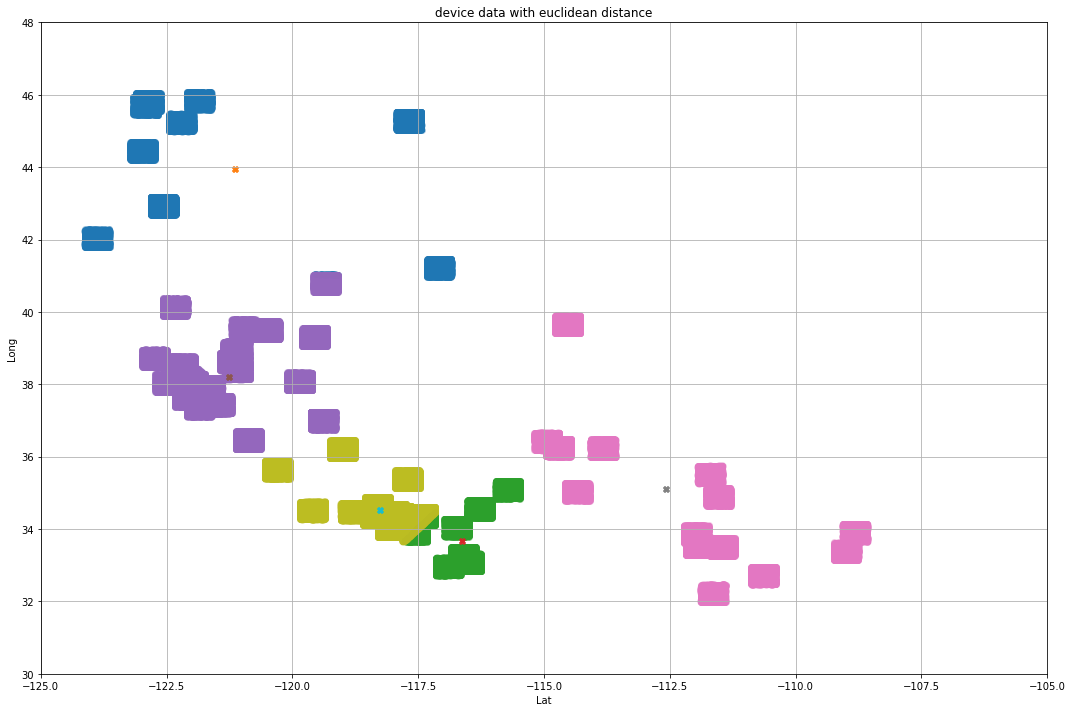

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_circle:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_circle[c[0]][0],cp_circle[c[0]][1], marker="X",alpha=1)
    ax.set_ylim((30,48))
    ax.set_xlim((-125,-105))
ax.set_xlabel('Lat', fontsize=10)
ax.set_ylabel('Long', fontsize=10)
ax.set_title('device data with euclidean distance')
ax.grid(True)
fig.tight_layout()

plt.show()

In [4]:
geo_data = sc.textFile("file:///home/mike/Dropbox/workspace/cse427s/k-means/Milestone3/Visualize/synthetic_location_data")\
.map(lambda o: o.split('\t')).filter(lambda o : len(o) != 1).map(lambda o: (float(o[1]), float(o[0]))).cache()

In [15]:
cp_geo_euc, clusters_geo_euc = kmeans_cluster(geo_data, 0.01, euclidean_distance, 2)

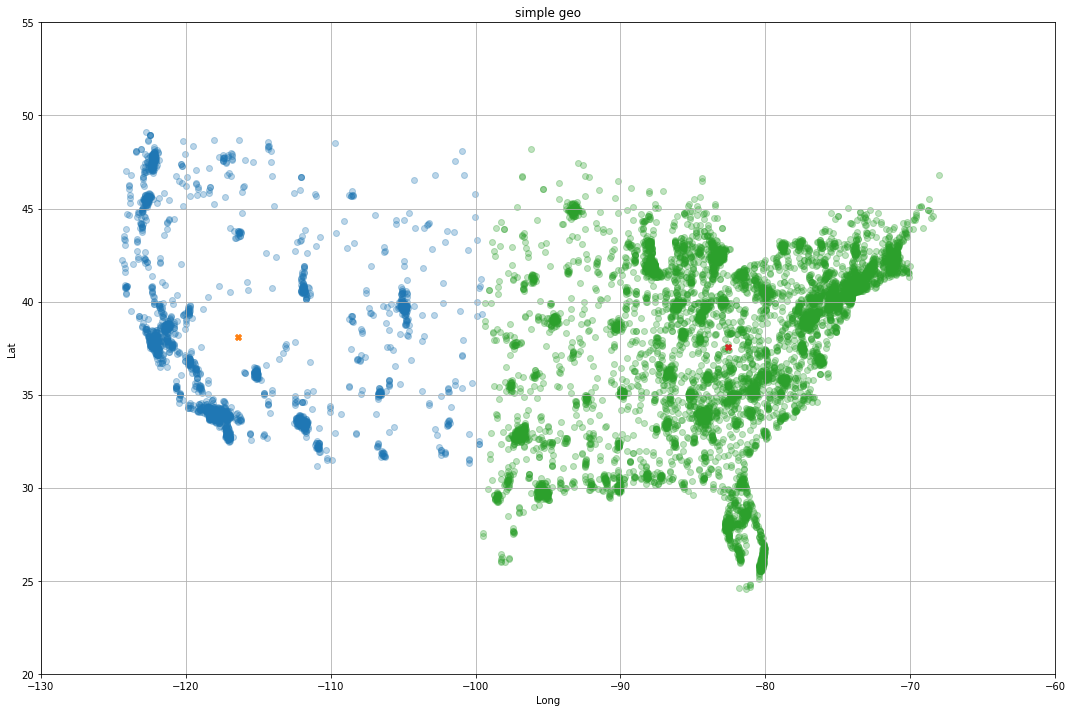

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_geo_euc:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_geo_euc[c[0]][0],cp_geo_euc[c[0]][1], marker="X",alpha=1)
    ax.set_ylim((20,55))
    ax.set_xlim((-130,-60))
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [17]:
cp_geo_cir, clusters_geo_cir = kmeans_cluster(geo_data, 0.01, great_circle_distance, 2)

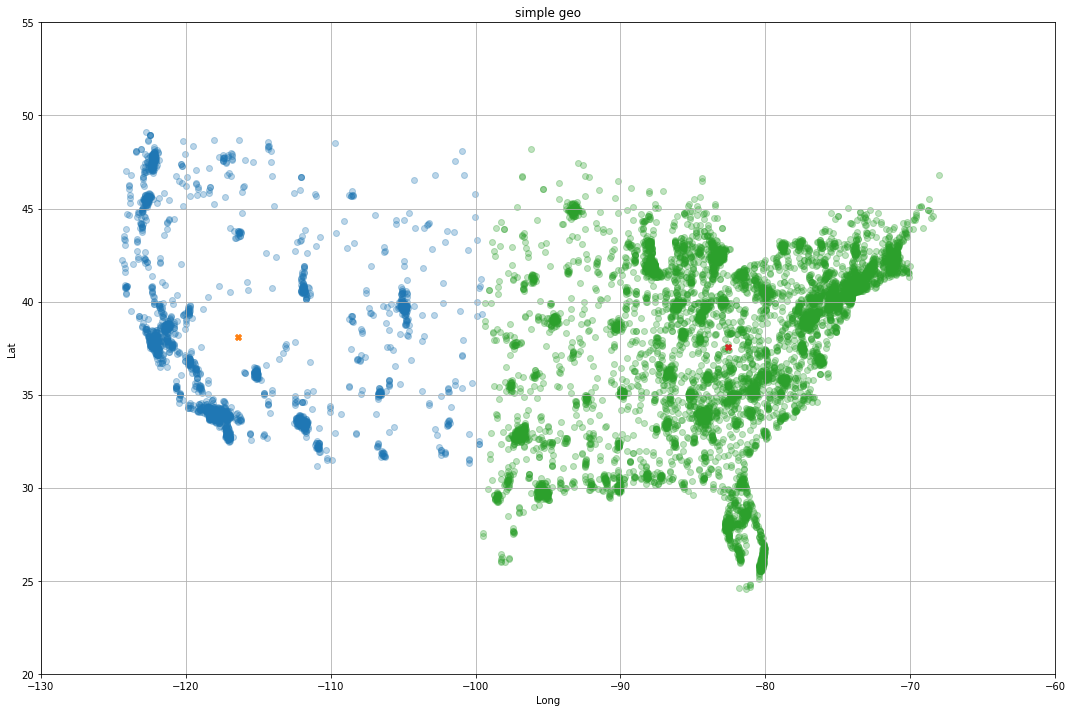

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_geo_cir:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_geo_cir[c[0]][0],cp_geo_cir[c[0]][1], marker="X",alpha=1)
    ax.set_ylim((20,55))
    ax.set_xlim((-130,-60))
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [19]:
cp_geo_euc_f, clusters_geo_euc_f = kmeans_cluster(geo_data, 0.01, euclidean_distance, 4)

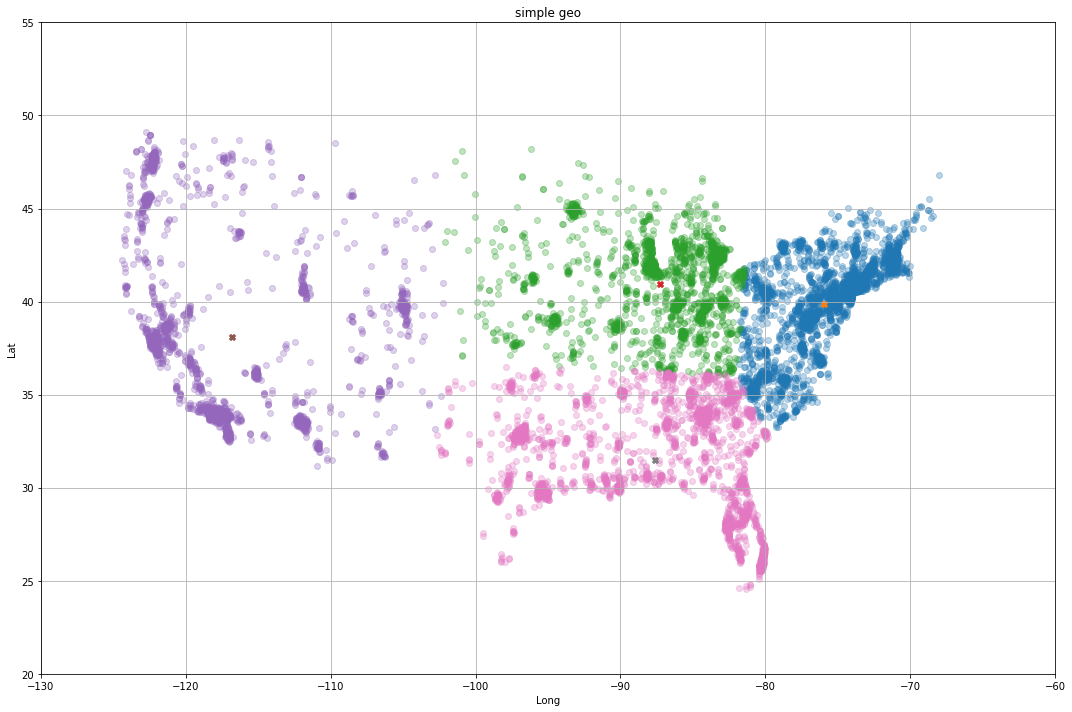

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_geo_euc_f:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_geo_euc_f[c[0]][0],cp_geo_euc_f[c[0]][1], marker="X",alpha=1)
    ax.set_ylim((20,55))
    ax.set_xlim((-130,-60))
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [21]:
cp_geo_cir_f, clusters_geo_cir_f = kmeans_cluster(geo_data, 0.01, great_circle_distance, 4)

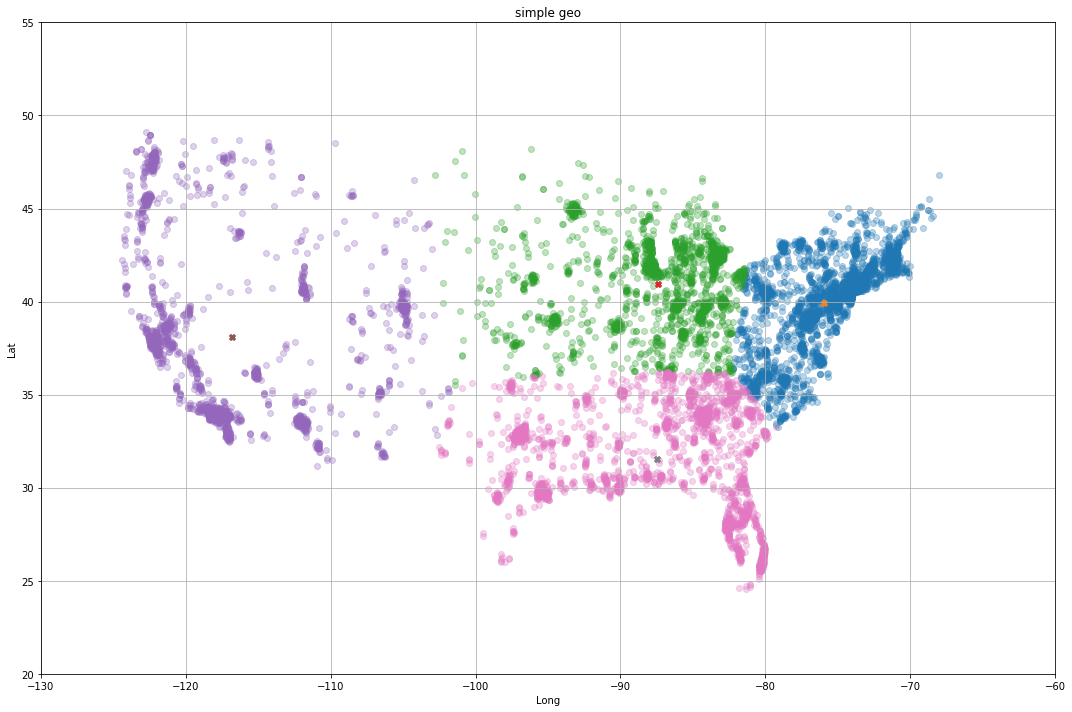

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_geo_cir_f:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_geo_cir_f[c[0]][0],cp_geo_cir_f[c[0]][1], marker="X",alpha=1)
    ax.set_ylim((20,55))
    ax.set_xlim((-130,-60))
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [5]:
wiki_data = sc.textFile("file:///home/mike/Dropbox/workspace/cse427s/k-means/Milestone3/Visualize/DBpedia_location_data")\
.map(lambda o: o.split(' ')).map(lambda o: (float(o[1]), float(o[0]))).cache()

In [24]:
cp_wiki_euc, clusters_wiki_euc = kmeans_cluster(wiki_data, 0.01, euclidean_distance, 6)

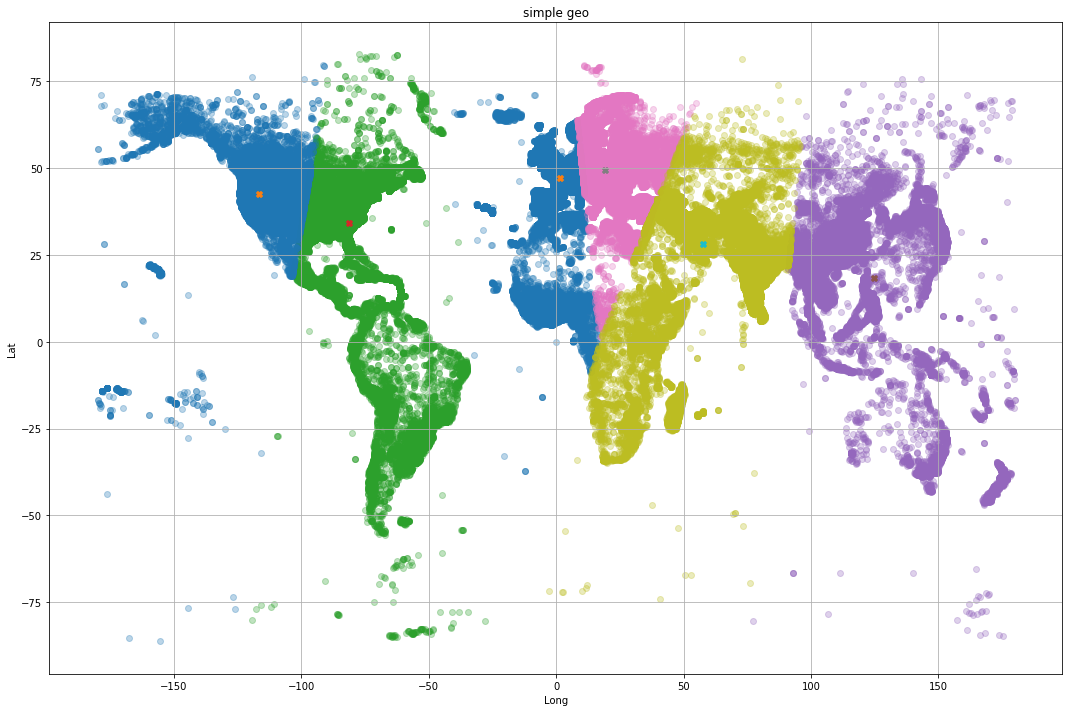

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_wiki_euc:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_wiki_euc[c[0]][0],cp_wiki_euc[c[0]][1], marker="X",alpha=1)
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [26]:
cp_wiki_cir, clusters_wiki_cir = kmeans_cluster(wiki_data, 0.01, great_circle_distance, 6)

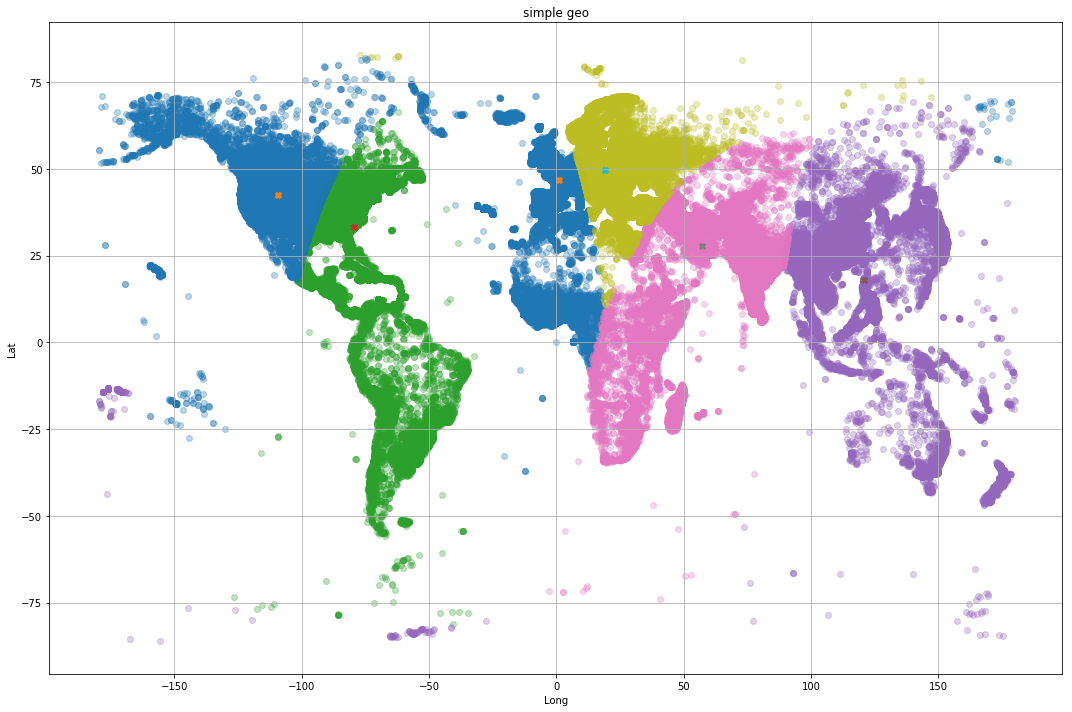

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_wiki_cir:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_wiki_cir[c[0]][0],cp_wiki_cir[c[0]][1], marker="X",alpha=1)
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [28]:
cp_wiki_euc_t, clusters_wiki_euc_t= kmeans_cluster(wiki_data, 0.01, euclidean_distance, 2)

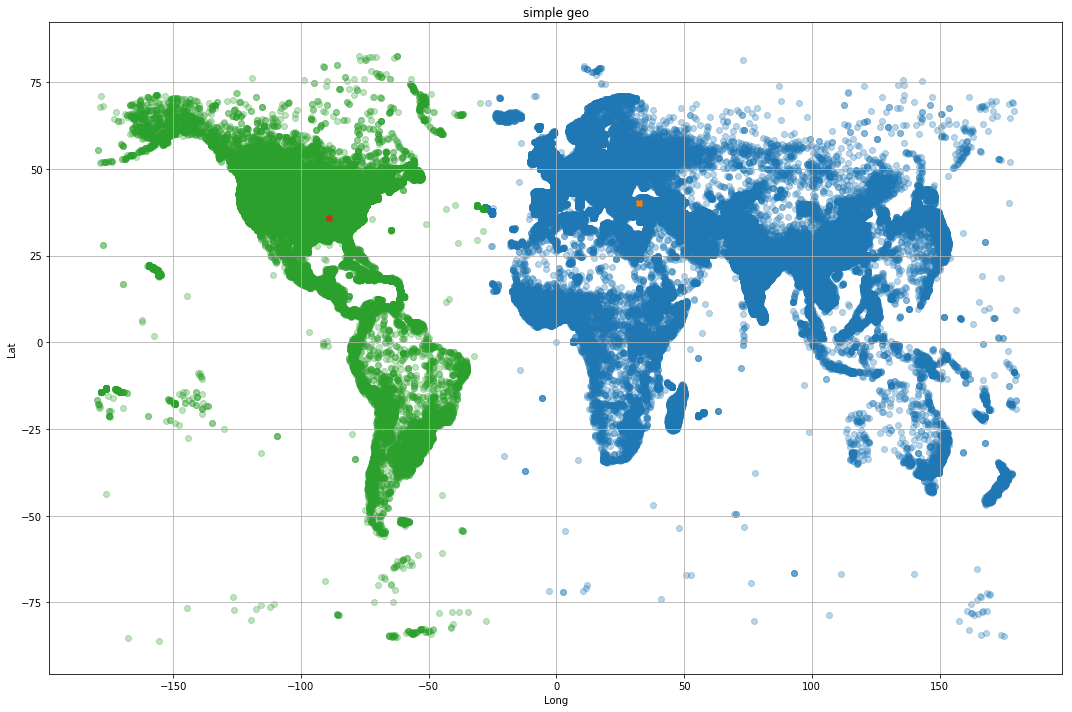

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_wiki_euc_t:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_wiki_euc_t[c[0]][0],cp_wiki_euc_t[c[0]][1], marker="X",alpha=1)
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [30]:
cp_wiki_cir_t, clusters_wiki_cir_t = kmeans_cluster(wiki_data, 0.01, great_circle_distance, 2)

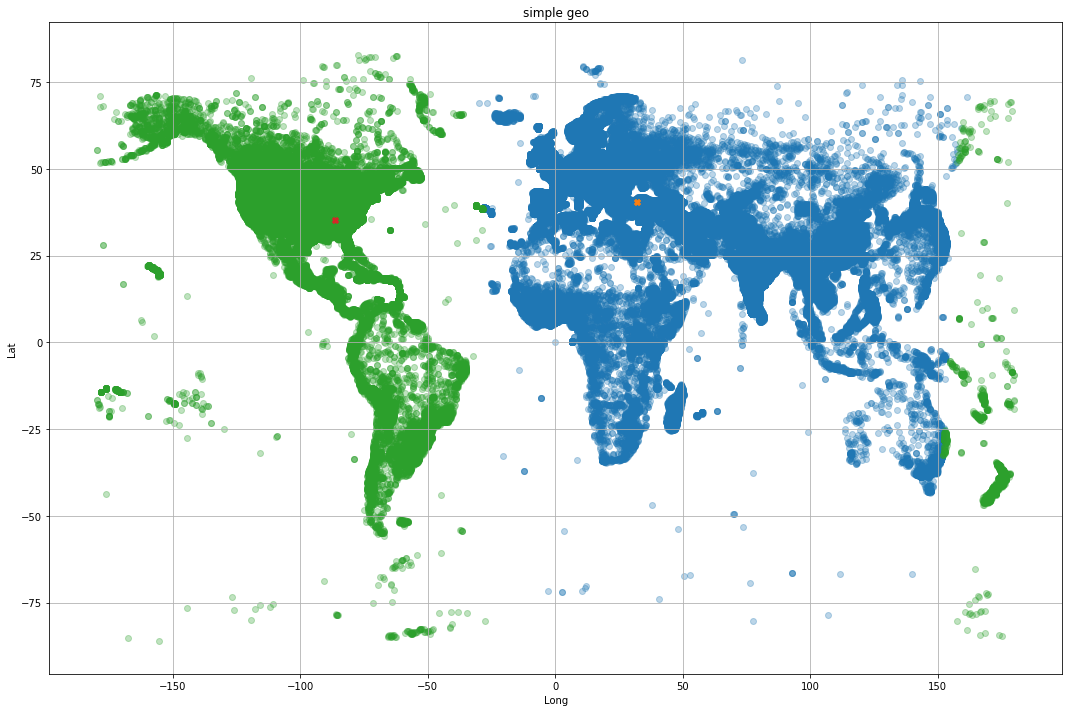

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_wiki_cir_t:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_wiki_cir_t[c[0]][0],cp_wiki_cir_t[c[0]][1], marker="X",alpha=1)
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [32]:
cp_wiki_euc_11, clusters_wiki_euc_11 = kmeans_cluster(wiki_data, 0.01, euclidean_distance, 11)

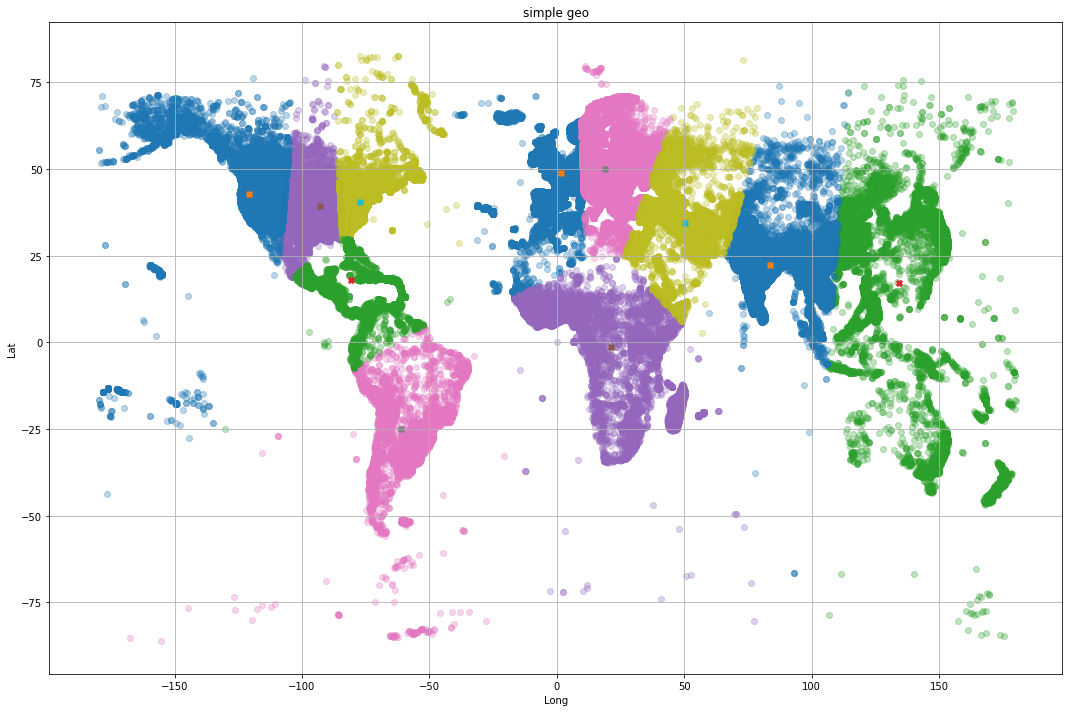

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_wiki_euc_11:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_wiki_euc_11[c[0]][0],cp_wiki_euc_11[c[0]][1], marker="X",alpha=1)
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [34]:
cp_wiki_cir_11, clusters_wiki_cir_11 = kmeans_cluster(wiki_data, 0.01, great_circle_distance, 11)

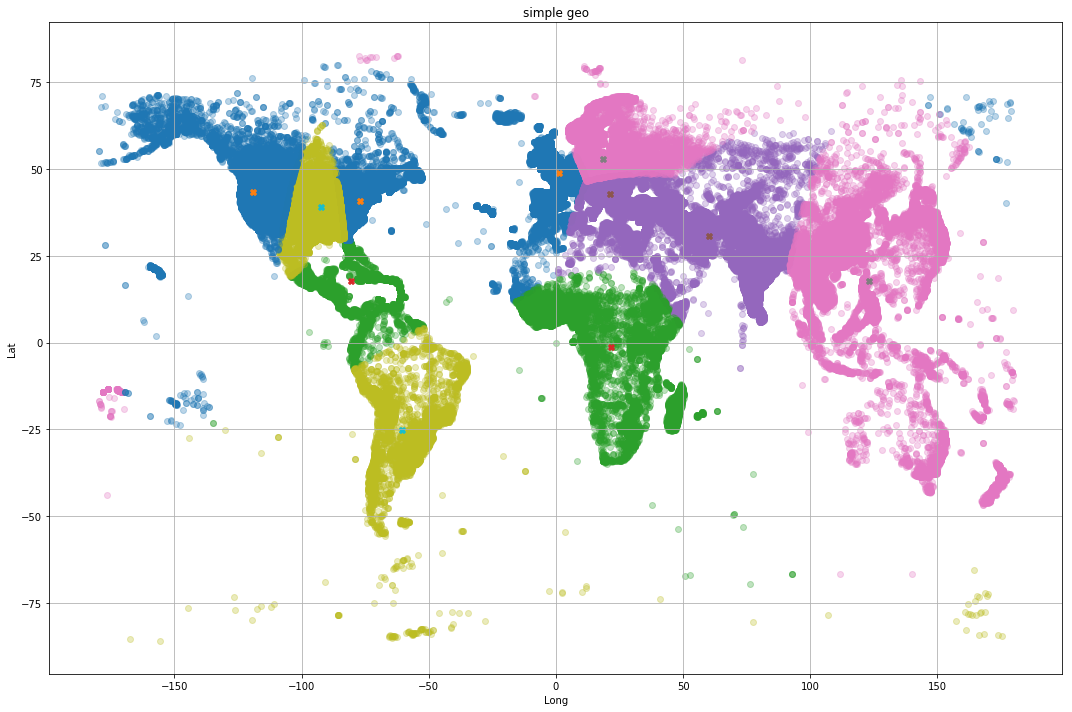

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))
for c in clusters_wiki_cir_11:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_wiki_cir_11[c[0]][0],cp_wiki_cir_11[c[0]][1], marker="X",alpha=1)
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [19]:
sample = wiki_data.takeSample(False, 2000, 20181209)

In [10]:
import pandas as pd
from pyspark.sql import SparkSession

In [20]:
pdf = pd.DataFrame(sample)

In [21]:
spark = SparkSession.builder.appName("PythonKMeans").getOrCreate()
# spark.conf.set("spark.sql.execution.arrow.enabled", "true")
sample = spark.createDataFrame(pdf).rdd.map(tuple)

In [22]:
cp_rand, clusters_rand = kmeans_cluster(sample, 0.01, euclidean_distance, 4)

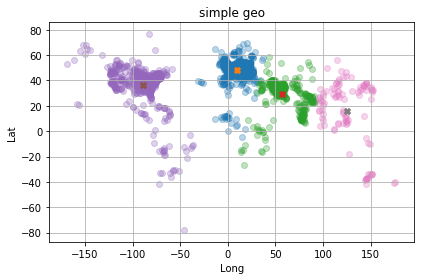

In [23]:
fig, ax = plt.subplots()
for c in clusters_rand:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_rand[c[0]][0],cp_rand[c[0]][1], marker="X",alpha=1)
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [24]:
cp_rand_cir, clusters_rand_cir = kmeans_cluster(sample, 0.01, great_circle_distance, 4)

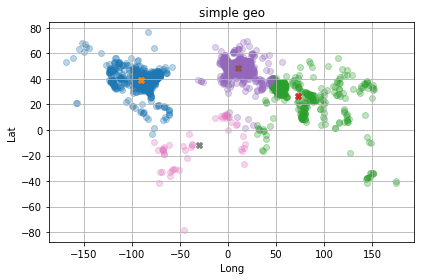

In [25]:
fig, ax = plt.subplots()
for c in clusters_rand_cir:
    ax.scatter(*zip(*c[1]) ,alpha=0.3)
    ax.scatter(cp_rand_cir[c[0]][0],cp_rand_cir[c[0]][1], marker="X",alpha=1)
# ax.set_ylim((20,55))
# ax.set_xlim((-130,-60))
ax.set_xlabel('Long', fontsize=10)
ax.set_ylabel('Lat', fontsize=10)
ax.set_title('simple geo')
ax.grid(True)
fig.tight_layout()

plt.show()

In [26]:
from pyspark import SparkConf
import timeit

In [ ]:
# spark with two threads

In [27]:
conf = SparkConf().setMaster("local[2]").setAppName("multithread")
sc.stop()
sc = SparkContext(conf=conf)

In [38]:
%time output = [kmeans_cluster(data, 0.01, euclidean_distance, 5) for _ in range(10)]

CPU times: user 1.62 s, sys: 188 ms, total: 1.81 s
Wall time: 4min 39s


In [39]:
%time output = [kmeans_cluster(data, 0.01, great_circle_distance, 5) for _ in range(10)]

CPU times: user 1.51 s, sys: 240 ms, total: 1.75 s
Wall time: 5min 49s


In [42]:
%time output = [kmeans_cluster(geo_data, 0.01, euclidean_distance, 2) for _ in range(10)]

CPU times: user 1.4 s, sys: 156 ms, total: 1.55 s
Wall time: 18.9 s


In [43]:
%time output = [kmeans_cluster(geo_data, 0.01, great_circle_distance, 2) for _ in range(10)]

CPU times: user 1.11 s, sys: 104 ms, total: 1.22 s
Wall time: 16.3 s


In [44]:
%time output = [kmeans_cluster(geo_data, 0.01, euclidean_distance, 4) for _ in range(10)]

CPU times: user 1.76 s, sys: 178 ms, total: 1.94 s
Wall time: 23.8 s


In [45]:
%time output = [kmeans_cluster(geo_data, 0.01, great_circle_distance, 4) for _ in range(10)]

CPU times: user 1.35 s, sys: 123 ms, total: 1.47 s
Wall time: 19.3 s


In [48]:
%time output = [kmeans_cluster(wiki_data, 0.01, euclidean_distance, 2) for _ in range(10)]

CPU times: user 760 ms, sys: 192 ms, total: 951 ms
Wall time: 1min 50s


In [49]:
%time output = [kmeans_cluster(wiki_data, 0.01, great_circle_distance, 2) for _ in range(10)]

CPU times: user 1.1 s, sys: 178 ms, total: 1.28 s
Wall time: 3min 53s


In [50]:
%time output = [kmeans_cluster(wiki_data, 0.01, euclidean_distance, 6) for _ in range(10)]

CPU times: user 2.04 s, sys: 300 ms, total: 2.34 s
Wall time: 9min 1s


In [51]:
%time output = [kmeans_cluster(wiki_data, 0.01, great_circle_distance, 6) for _ in range(10)]

CPU times: user 1.6 s, sys: 213 ms, total: 1.81 s
Wall time: 8min 22s


In [52]:
%time output = [kmeans_cluster(wiki_data, 0.01, euclidean_distance, 11) for _ in range(10)]

CPU times: user 3.29 s, sys: 449 ms, total: 3.74 s
Wall time: 18min 8s


In [53]:
%time output = [kmeans_cluster(wiki_data, 0.01, great_circle_distance, 11) for _ in range(10)]

CPU times: user 2.29 s, sys: 303 ms, total: 2.59 s
Wall time: 15min 27s


In [ ]:
# spark with 4 threads

In [56]:
conf = SparkConf().setMaster("local[4]").setAppName("multithread")
sc.stop()
sc = SparkContext(conf=conf)

In [62]:
%time output = [kmeans_cluster(data, 0.01, euclidean_distance, 5) for _ in range(10)]

CPU times: user 1.71 s, sys: 236 ms, total: 1.95 s
Wall time: 4min 23s


In [63]:
%time output = [kmeans_cluster(data, 0.01, great_circle_distance, 5) for _ in range(10)]

CPU times: user 1.68 s, sys: 202 ms, total: 1.89 s
Wall time: 5min 52s


In [64]:
%time output = [kmeans_cluster(geo_data, 0.01, euclidean_distance, 2) for _ in range(10)]

CPU times: user 1.48 s, sys: 162 ms, total: 1.64 s
Wall time: 18.2 s


In [65]:
%time output = [kmeans_cluster(geo_data, 0.01, great_circle_distance, 2) for _ in range(10)]

CPU times: user 1.17 s, sys: 138 ms, total: 1.31 s
Wall time: 17.5 s


In [66]:
%time output = [kmeans_cluster(geo_data, 0.01, euclidean_distance, 4) for _ in range(10)]

CPU times: user 1.8 s, sys: 185 ms, total: 1.98 s
Wall time: 24.8 s


In [67]:
%time output = [kmeans_cluster(geo_data, 0.01, great_circle_distance, 4) for _ in range(10)]

CPU times: user 1.32 s, sys: 136 ms, total: 1.45 s
Wall time: 18.7 s


In [68]:
%time output = [kmeans_cluster(wiki_data, 0.01, euclidean_distance, 2) for _ in range(10)]

CPU times: user 795 ms, sys: 151 ms, total: 946 ms
Wall time: 1min 46s


In [69]:
%time output = [kmeans_cluster(wiki_data, 0.01, great_circle_distance, 2) for _ in range(10)]

CPU times: user 1.12 s, sys: 190 ms, total: 1.31 s
Wall time: 3min 58s


In [70]:
%time output = [kmeans_cluster(wiki_data, 0.01, euclidean_distance, 6) for _ in range(10)]

CPU times: user 2.03 s, sys: 254 ms, total: 2.28 s
Wall time: 8min 37s


In [71]:
%time output = [kmeans_cluster(wiki_data, 0.01, great_circle_distance, 6) for _ in range(10)]

CPU times: user 1.6 s, sys: 262 ms, total: 1.86 s
Wall time: 8min 20s


In [72]:
%time output = [kmeans_cluster(wiki_data, 0.01, euclidean_distance, 11) for _ in range(10)]

CPU times: user 3.22 s, sys: 429 ms, total: 3.65 s
Wall time: 17min 13s


In [73]:
%time output = [kmeans_cluster(wiki_data, 0.01, great_circle_distance, 11) for _ in range(10)]

CPU times: user 2.51 s, sys: 336 ms, total: 2.85 s
Wall time: 15min 30s


In [ ]:
# spark with single threads

In [74]:
conf = SparkConf().setMaster("local").setAppName("singlethread")
sc.stop()
sc = SparkContext(conf=conf)

In [78]:
%time output = [kmeans_cluster(data, 0.01, euclidean_distance, 5) for _ in range(10)]

CPU times: user 1.76 s, sys: 267 ms, total: 2.03 s
Wall time: 7min 40s


In [79]:
%time output = [kmeans_cluster(data, 0.01, great_circle_distance, 5) for _ in range(10)]

CPU times: user 1.5 s, sys: 234 ms, total: 1.74 s
Wall time: 10min 27s


In [80]:
%time output = [kmeans_cluster(geo_data, 0.01, euclidean_distance, 2) for _ in range(10)]

CPU times: user 518 ms, sys: 71.6 ms, total: 590 ms
Wall time: 8.57 s


In [81]:
%time output = [kmeans_cluster(geo_data, 0.01, great_circle_distance, 2) for _ in range(10)]

CPU times: user 584 ms, sys: 30.1 ms, total: 614 ms
Wall time: 13.4 s


In [82]:
%time output = [kmeans_cluster(geo_data, 0.01, euclidean_distance, 4) for _ in range(10)]

CPU times: user 1.05 s, sys: 100 ms, total: 1.15 s
Wall time: 19.3 s


In [83]:
%time output = [kmeans_cluster(geo_data, 0.01, great_circle_distance, 4) for _ in range(10)]

CPU times: user 1.43 s, sys: 154 ms, total: 1.59 s
Wall time: 35.6 s


In [84]:
%time output = [kmeans_cluster(wiki_data, 0.01, euclidean_distance, 2) for _ in range(10)]

CPU times: user 914 ms, sys: 141 ms, total: 1.06 s
Wall time: 4min 5s


In [85]:
%time output = [kmeans_cluster(wiki_data, 0.01, great_circle_distance, 2) for _ in range(10)]

CPU times: user 1.18 s, sys: 218 ms, total: 1.4 s
Wall time: 7min 48s


In [86]:
%time output = [kmeans_cluster(wiki_data, 0.01, euclidean_distance, 6) for _ in range(10)]

CPU times: user 1.94 s, sys: 263 ms, total: 2.2 s
Wall time: 14min 37s


In [87]:
%time output = [kmeans_cluster(wiki_data, 0.01, great_circle_distance, 6) for _ in range(10)]

CPU times: user 1.99 s, sys: 307 ms, total: 2.3 s
Wall time: 19min 40s


In [88]:
%time output = [kmeans_cluster(wiki_data, 0.01, euclidean_distance, 11) for _ in range(10)]

CPU times: user 3.15 s, sys: 385 ms, total: 3.53 s
Wall time: 30min 32s


In [89]:
%time output = [kmeans_cluster(wiki_data, 0.01, great_circle_distance, 11) for _ in range(10)]

CPU times: user 4.31 s, sys: 491 ms, total: 4.8 s
Wall time: 59min 15s


In [ ]:
# without RDD numpy k-means implementation

In [90]:
sc.stop()
sc = SparkContext()

In [6]:
def sampleCenter(data, k):
    ds = data.copy()
    np.random.shuffle(ds)
    return ds[:k]

In [7]:
def euclidean_np(points, cp):
    return np.sqrt(((points - cp[:, np.newaxis])**2).sum(axis=2))

In [68]:
def gcd_np(points, cp):
    lat1, lon1 = np.radians(cp[:, 1]), np.radians(cp[:, 0])
    lat2, lon2 = np.radians(points[:, 1]), np.radians(points[:, 0])

    sin_lat1, cos_lat1 = np.sin(lat1), np.cos(lat1)
    sin_lat2, cos_lat2 = np.sin(lat2), np.cos(lat2)

    sin_lon1, cos_lon1 = np.sin(lon1), np.cos(lon1)
    sin_lon2, cos_lon2 = np.sin(lon2), np.cos(lon2)


    d_X = cos_lat2 * cos_lon2 - (cos_lat1 * cos_lon1)[:, np.newaxis]
    d_Y = cos_lat2 * sin_lon2 - (cos_lat1 * sin_lon1)[:, np.newaxis]
    d_Z = sin_lat2 - sin_lat1[:, np.newaxis]

    C = np.sqrt(d_X ** 2 + d_Y ** 2 + d_Z ** 2)
    return 2 * np.arcsin(C / 2)

In [19]:
def closest_np(points, cp, m):
    return np.argmin(m(points, cp), axis=0)

In [69]:
def kmeans_cluster_np(data, converge_dist, m, k):
    ds = np.array(data.collect())
    cp = sampleCenter(ds, k)
    temp_dist = 1.0
    while temp_dist > converge_dist:
        closest = closest_np(ds.copy(), cp, m)
        point_stats = np.array([ds.copy()[closest==i].mean(axis=0) for i in range(cp.shape[0])])

        temp_dist = sum(np.sum((point_stats - cp)**2, axis=1))
        cp = point_stats.copy()
    clusters = closest_np(ds.copy(), cp, euclidean_np)
    clusters = np.array([ds[clusters==i] for i in range(cp.shape[0])])
    return cp, clusters

In [40]:
%time output = [kmeans_cluster_np(data, 0.01, euclidean_np, 5) for _ in range(10)]

CPU times: user 31.3 s, sys: 1.5 s, total: 32.8 s
Wall time: 9.76 s


In [76]:
%time output = [kmeans_cluster_np(data, 0.01, gcd_np, 5) for _ in range(10)]

CPU times: user 29.2 s, sys: 1.01 s, total: 30.2 s
Wall time: 8.48 s


In [21]:
%time output = [kmeans_cluster_np(geo_data, 0.01, euclidean_np, 2) for _ in range(10)]

CPU times: user 578 ms, sys: 31.6 ms, total: 610 ms
Wall time: 568 ms


In [77]:
%time output = [kmeans_cluster_np(geo_data, 0.01, gcd_np, 2) for _ in range(10)]

CPU times: user 1.22 s, sys: 71.3 ms, total: 1.29 s
Wall time: 466 ms


In [22]:
%time output = [kmeans_cluster_np(geo_data, 0.01, euclidean_np, 4) for _ in range(10)]

CPU times: user 1.72 s, sys: 133 ms, total: 1.85 s
Wall time: 1 s


In [78]:
%time output = [kmeans_cluster_np(geo_data, 0.01, gcd_np, 4) for _ in range(10)]

CPU times: user 1.66 s, sys: 67.5 ms, total: 1.73 s
Wall time: 550 ms


In [23]:
%time output = [kmeans_cluster_np(wiki_data, 0.01, euclidean_np, 2) for _ in range(10)]

CPU times: user 22.3 s, sys: 1.29 s, total: 23.6 s
Wall time: 9.43 s


In [79]:
%time output = [kmeans_cluster_np(wiki_data, 0.01, gcd_np, 2) for _ in range(10)]

CPU times: user 22.2 s, sys: 995 ms, total: 23.2 s
Wall time: 8.6 s


In [24]:
%time output = [kmeans_cluster_np(wiki_data, 0.01, euclidean_np, 6) for _ in range(10)]

CPU times: user 1min 42s, sys: 9.62 s, total: 1min 51s
Wall time: 32.5 s


In [80]:
%time output = [kmeans_cluster_np(wiki_data, 0.01, gcd_np, 6) for _ in range(10)]

CPU times: user 1min 28s, sys: 10.4 s, total: 1min 38s
Wall time: 28.6 s


In [25]:
%time output = [kmeans_cluster_np(wiki_data, 0.01, euclidean_np, 11) for _ in range(10)]

CPU times: user 3min 27s, sys: 21.9 s, total: 3min 49s
Wall time: 1min 3s


In [81]:
%time output = [kmeans_cluster_np(wiki_data, 0.01, gcd_np, 11) for _ in range(10)]

CPU times: user 2min 3s, sys: 25.7 s, total: 2min 28s
Wall time: 42.5 s
